## 1) Introduction

This simple notebook implements the mathematical forward models whose descriptions can be found [in this document](https://www.overleaf.com/project/623dc6078b3a6b1b29dfcc5a) (needs to be invited).

In [1]:
# The modules to import
from os import path
import numpy as np
from scipy.signal import convolve2d 
from PIL import Image
import matplotlib.pyplot as plt
from netCDF4 import Dataset


def plot_images(images_list, titles_list, nrows=1, ncols=None, save_to=None, police_color=None):
    n = len(images_list)
    if not ncols:
        ncols = n

    if not police_color:
        police_color = "white"
    
    plt.figure(figsize=(40, 40))

    for i in range(n):
        if len(images_list[i].shape) == 3 and images_list[i].shape[2] == 3:
            plt.subplot(nrows, ncols, i + 1)
            plt.imshow(np.flip(images_list[i], axis=2))
        
        else:
            plt.subplot(nrows, ncols, i + 1)
            plt.imshow(images_list[i], cmap='gray')
        
        plt.title(titles_list[i], color=police_color, fontsize=32)
        plt.xticks(color=police_color, fontsize=24)
        plt.yticks(color=police_color, fontsize=24)

    if save_to:
        plt.savefig(save_to)

    plt.show()

## 2) Input setup

Concerning the dimensions, like in the document we have :
* `N_i` the amount of pixels in a column;
* `N_j` the amount of pixels in a row;
* `N_ij` the product of `N_i` and `N_j`;
* `N_k` the amount of channels;
* `N_ijk` the product of `N_ij` and `N_k`.

We retreive the input scene from a netCDF4 file and put it in the 3 dimensional matrix `Ux`, corresponding to the $U^{[x]}$ matrix in the document.

Then we instanciate the matrix `X`, which is `Ux` whose 2nd space dimension is flattened (corresponding to $X$). We also flatten `X` into `x`.

Finally we get the `spectral_stencil`, the ordered array of the sampled wavelengths (in Ångström).

We define also a second pair of data, much smaller to be printed.

In [2]:
dataset = Dataset(path.join("data", "multispectral_colorchecker.ns"), 'r')
dataset.set_auto_mask(False)

# Declaration of Ux
Ux_1 = dataset.groups['radiance group'].variables['radiance matrix'][:, :, :].astype(float)
Ux_2 = np.zeros((10, 10, 3))

for i in range(10):
    for j in range(10):
        Ux_2[i, j] = [np.random.choice([0,1]), np.random.choice([0,1]), np.random.choice([0,1])]

Ux_3 = np.flip(np.asarray(Image.open(path.join("data", "tarkus.jpg")).resize((100, 100))), axis=2)

# Declaration of the spectral stencil
spectral_stencil_1 = dataset.variables['spectral stencil'][:]
spectral_stencil_2 = np.array([4400, 5500, 6500])

# We decide which input to use
Ux = Ux_3
spectral_stencil = spectral_stencil_2

# Declaration of the dimensions
N_i, N_j, N_k = Ux.shape
N_ij = N_i * N_j
N_ijk = N_ij * N_k

# Declaration of X
X = np.zeros((N_ij, N_k))

for k in range(N_k):
    X[:, k] = Ux[:, :, k].flatten('F')

# Declaration of x
x = X.flatten('F')

## 3) Mask creation

In this part we declare `k_r`, `k_g` and `k_b`, the indices of the colors red, green and blue in the spectral stencil.

Then we construct the 3 dimensional matrices `UBayer` and `UQuad`. They are the implementation of the Bayer CFA and the Quad-Bayer CFA.

See $U^{[Bayer]}$ and $U^{[Quad]}$ in the document for more informations.

Like for `X`, we introduce `HBayer` and `HQuad`, the flatened versions of `UBayer` and `UQuad`.

We compute the two mask matrices with those expressions :

$$
\mathcal{U}^{[Bayer]}_{i, j, k} =
\left\{
\begin{array}{lll}
    1 & \text{if $k = k_r$ and} & \text{$i \bmod{2} = 0$ and $j \bmod{2} = 1$}\\
    1 & \text{if $k = k_g$ and} & \text{(($i \bmod{2} = 0$ and $j \bmod{2} = 0$) or}\\
    && \text{($i \bmod{2} = 1$ and $j \bmod{2} = 1$))}\\
    1 & \text{if $k = k_b$ and} & \text{$i \bmod{2} = 1$ and $j \bmod{2} = 0$}\\
    0 & \text{otherwise}
\end{array}
\right.

\text{and} \quad

\mathcal{U}^{[Quad]}_{i, j, k} =
\left\{
\begin{array}{lll}
    1 & \text{if $k = k_r$ and} & \text{$i \bmod{4} < 2$ and $j \bmod{4} \geq 2$}\\
    1 & \text{if $k = k_g$ and} & \text{(($i \bmod{4} < 2$ and $j \bmod{4} < 2$) or}\\
    && \text{($i \bmod{4} \geq 2$ and $j \bmod{4} \geq 2$))}\\
    1 & \text{if $k = k_b$ and} & \text{$i \bmod{4} \geq 2$ and $j \bmod{4} < 2$}\\
    0 & \text{otherwise}
\end{array}
\right.
$$

Finally we compute the matrices `ABayer` and `AQuad` that encode the operation.

In [3]:
# Declaration of the indices of the wavelength of the red, green and blue colors
k_r = (np.abs(spectral_stencil - 6500)).argmin()
k_g = (np.abs(spectral_stencil - 5500)).argmin()
k_b = (np.abs(spectral_stencil - 4450)).argmin()

# Declaration of UBayer and UQuad
UBayer = np.zeros_like(Ux)
UQuad = np.zeros_like(Ux)

for i in range(N_i):
    for j in range(N_j):
        for k in range(N_k):
            if k == k_r:
                if i % 2 == 0 and j % 2 == 1:
                    UBayer[i, j, k] = 1

                if i % 4 < 2 and j % 4 >= 2:
                    UQuad[i, j, k] = 1

            elif k == k_g:
                if (i % 2 == 0 and j % 2 == 0) or (i % 2 == 1 and j % 2 == 1):
                    UBayer[i, j, k] = 1

                if (i % 4 < 2 and j % 4 < 2) or (i % 4 >= 2 and j % 4 >= 2):
                    UQuad[i, j, k] = 1

            elif k == k_b:
                if i % 2 == 1 and j % 2 == 0:
                    UBayer[i, j, k] = 1

                if i % 4 >= 2 and j % 4 < 2:
                    UQuad[i, j, k] = 1

# Declaration of the flattened mask matrices
HBayer = np.zeros((N_ij, N_k))
HQuad = np.zeros((N_ij, N_k))

for k in range(N_k):
    HBayer[:, k] = UBayer[:, :, k].flatten('F')
    HQuad[:, k] = UQuad[:, :, k].flatten('F')

# Declaration of the matrices which will perform the operation
# ABayer = np.zeros((N_ij, N_ijk))
# AQuad = np.zeros((N_ij, N_ijk))

# for i in range(N_ij):
#     for j in range(N_ijk):
#         if i == j % N_ij:
#             ABayer[i, j] = HBayer[i, j // N_ij]
#             AQuad[i, j] = HQuad[i, j // N_ij]

## 4) Application of the masks

We use the formula :

$$
    y = \sum_{k = 1}^{N_k} X_{:k} \odot H_{:k}
$$

Or directly :

$$
    y = A^{CFA}x
$$

Where $y$ is a vector of $\mathbb{R}^{N_{ij}}$.

In [4]:
# Results of the masks
yBayer = sum(X[:, k] * HBayer[:, k] for k in range(N_k))
yQuad = sum(X[:, k] * HQuad[:, k] for k in range(N_k))

# Un-flatten the results
YBayer = np.reshape(yBayer, (N_i, N_j), order='F')
YQuad = np.reshape(yQuad, (N_i, N_j), order='F')

## 5) Binning matrix creation

In this part we define the matrix `B` to match the pattern of the Quad-Bayer CFA. This matrix will guide the computations during the binning (see the matrix $B$ in the document).

In [5]:
# Construcion of the matrix B
B = np.zeros((N_i, N_j))

for i in range(N_i):
    for j in range(N_j):
        if i % 2 == 0 and j % 2 == 0:
            B[i, j] = 2

## 6) Performing the binning

The operation is done by filling the output $Y^{bin}$ aggregated squares by aggregated squares.

We use the formula stating that $\forall (i, j) \in \{0, ..., N_{i} - 1\} \times \{0, ..., N_{j} - 1\}$ such that $B_{i, j} = l \ne 0$ we have :

$$
    Y^{bin}_{i:i + l - 1, j:j + l - 1} = \mathcal{A}(Y, i, j, l)
$$

In [6]:
# Result of the binning
Ybin = np.zeros((N_i, N_j))

for i in range(N_i):
    for j in range(N_j):
        l = int(B[i, j])
        if l != 0:
            l_i = ((i + l) >= N_i) * (N_i - i - l) + l
            l_j = ((j + l) >= N_j) * (N_j - j - l) + l
            
            mean_value = np.mean(YQuad[i:i + l_i, j:j + l_j])

            for ii in range(l_i):
                for jj in range(l_j):
                    Ybin[i + ii, j + jj] = mean_value

## 7) Visualization

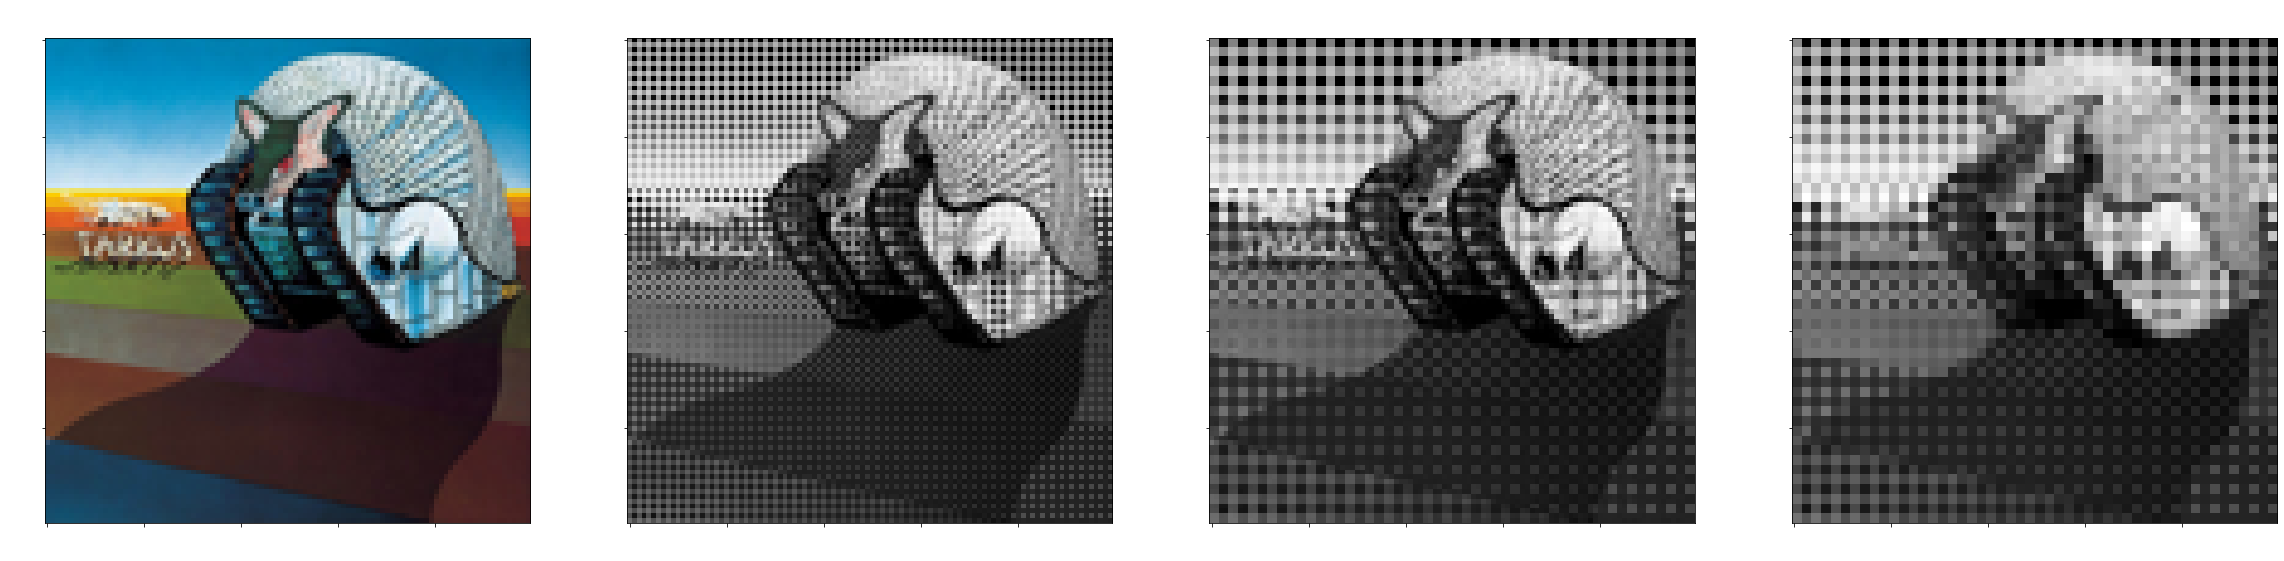

In [7]:
plot_images([Ux, YBayer, YQuad, Ybin], ["The input image Ux", "Output Bayer CFA YBayer", "Output Quad-Bayer CFA YQuad", "Output binning Ybin"])

## 8) Demosaicking



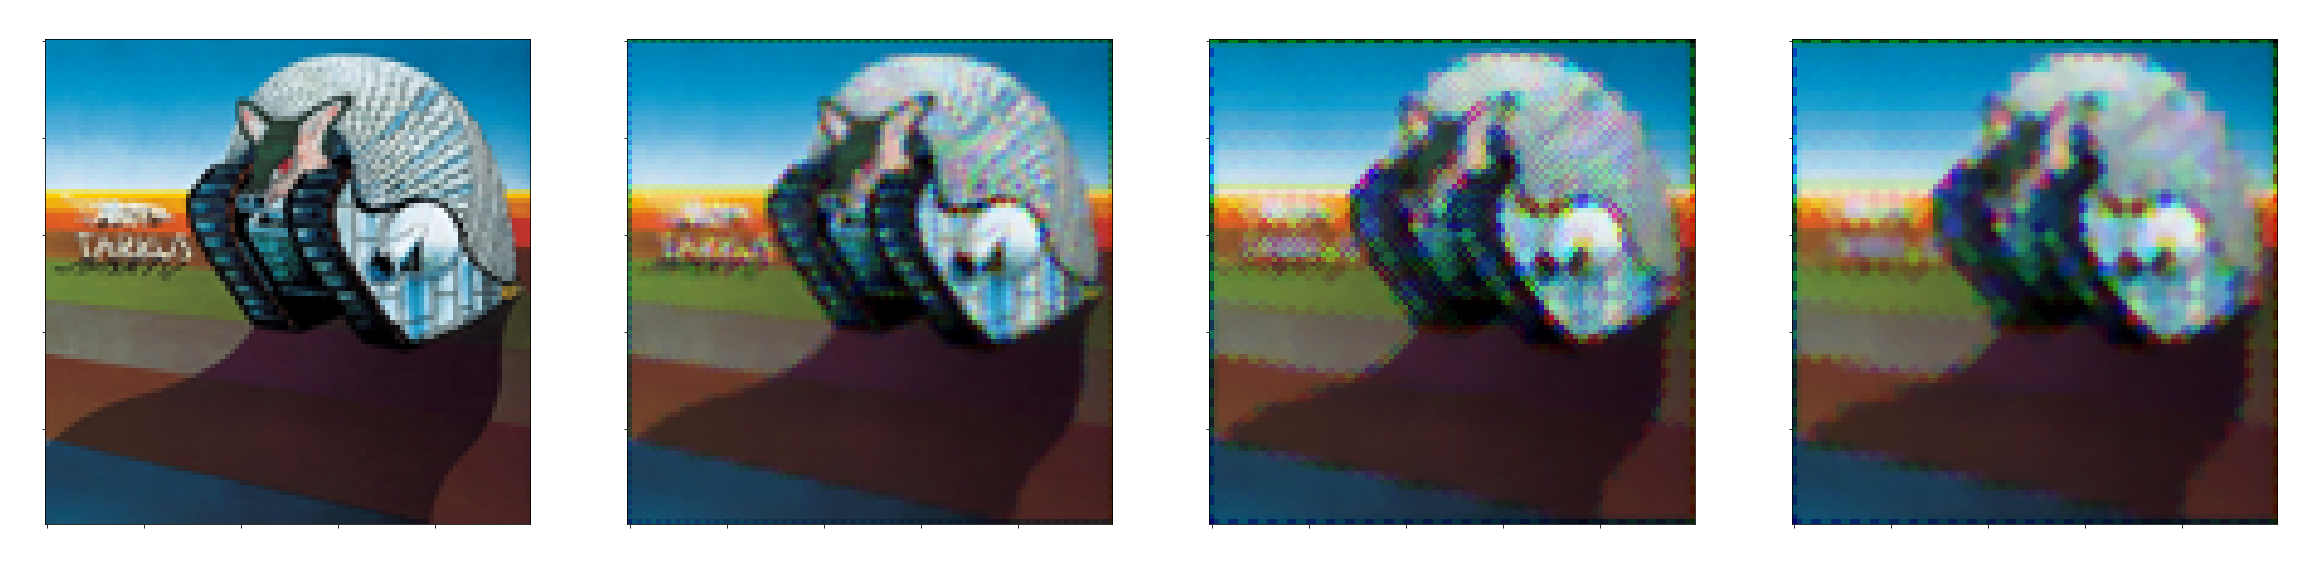

In [8]:
def demosaicking(Y, pattern='Bayer'):
    # Declaration of the kernels
    if pattern == "Bayer":
        ker_red_blue = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 4
        ker_green = np.array([[0, 1, 0], [1, 4, 1], [0, 1, 0]]) / 4

    elif pattern == "Quad-Bayer":
        ker_red_blue = np.array([[0, 1, 0, 1, 0], [1, 2, 2, 2, 1], [0, 2, 0, 2, 0], [1, 2, 2, 2, 1], [0, 1, 0, 1, 0]]) / 6
        ker_green = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 2

    # Reconstruction of the input
    Ux_hat = np.zeros((N_i, N_j, 3), dtype=np.uint8)

    for i in range(N_i):
        for j in range(N_j):
            if pattern == "Bayer":
                if i % 2 == 0 and j % 2 == 1:
                    Ux_hat[i, j, 2] = Y[i, j]

                elif (i % 2 == 0 and j % 2 == 0) or (i % 2 == 1 and j % 2 == 1):
                    Ux_hat[i, j, 1] = Y[i, j]

                elif i % 2 == 1 and j % 2 == 0:
                    Ux_hat[i, j, 0] = Y[i, j]

            elif pattern == "Quad-Bayer":
                if i % 4 < 2 and j % 4 >= 2:
                    Ux_hat[i, j, 2] = Y[i, j]

                elif (i % 4 < 2 and j % 4 < 2) or (i % 4 >= 2 and j % 4 >= 2):
                    Ux_hat[i, j, 1] = Y[i, j]

                elif i % 4 >= 2 and j % 4 < 2:
                    Ux_hat[i, j, 0] = Y[i, j]

    Ux_hat[:, :, 2] = convolve2d(Ux_hat[:, :, 2], ker_red_blue, mode="same")
    Ux_hat[:, :, 1] = convolve2d(Ux_hat[:, :, 1], ker_green, mode="same")
    Ux_hat[:, :, 0] = convolve2d(Ux_hat[:, :, 0], ker_red_blue, mode="same")

    return Ux_hat

Ux_hat_Bayer = demosaicking(YBayer)
Ux_hat_Quad = demosaicking(YQuad, pattern="Quad-Bayer")
Ux_hat_bin = demosaicking(Ybin, pattern="Quad-Bayer")

plot_images([Ux, Ux_hat_Bayer, Ux_hat_Quad, Ux_hat_bin], ["Input image Ux", "Reconstructed image Ux_hat_Bayer", "Reconstructed image Ux_hat_Quad", "Reconstructed image Ux_hat_bin"])